In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time
from keras.datasets import cifar10
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

# Feature graph

4166 > 4096 edges
Layer 0: M_0 = |V| = 1264 nodes (240 added),|E| = 4166 edges
Layer 1: M_1 = |V| = 632 nodes (92 added),|E| = 1895 edges
Layer 2: M_2 = |V| = 316 nodes (32 added),|E| = 895 edges
Layer 3: M_3 = |V| = 158 nodes (8 added),|E| = 432 edges
Layer 4: M_4 = |V| = 79 nodes (0 added),|E| = 214 edges
Execution time: 0.40s


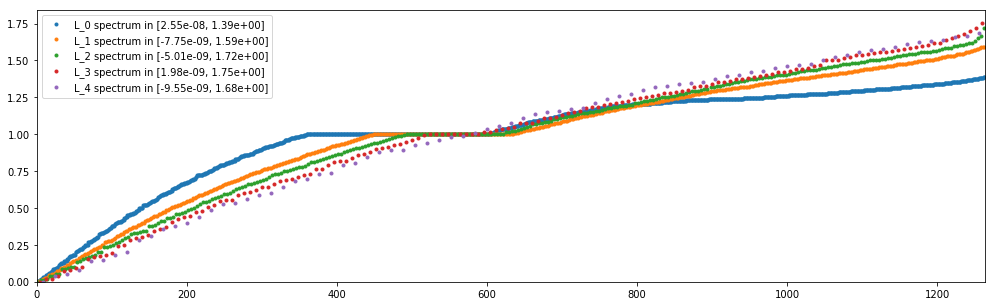

In [30]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(32, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
del A

# Data

In [32]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2],X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2],X_test.shape[3])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

rand_perm = np.random.permutation(X_train.shape[0])
r = 45000

train_data = X_train[rand_perm[0:r],:,:]
val_data = X_train[rand_perm[r:],:,:]
test_data = X_test
train_labels = np_utils.to_categorical(y_train[rand_perm[0:r]])
val_labels = np_utils.to_categorical(y_train[rand_perm[r:]])
test_labels = np_utils.to_categorical(y_test)

#train_data = X_train[rand_perm[0:r],:,0]
#val_data = X_train[rand_perm[r:],:,0]
#test_data = X_test[:,:,0]

print(len(perm))
print(train_data.shape, test_data.shape, val_data.shape)
t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#del perm,X_train,X_test

1264
(45000, 1024, 3) (10000, 1024, 3) (5000, 1024, 3)
Execution time: 7.73s


# Neural networks

In [5]:
#model = fc1()
#model = fc2(nhiddens=100)
#model = cnn2(K=5, F=10)  # K=28 is equivalent to filtering with fgcnn.
#model = fcnn2(F=10)
#model = fgcnn2(L[0], F=10)
#model = lgcnn2_2(L[0], F=10, K=10)
#model = cgcnn2_3(L[0], F=10, K=5)
#model = cgcnn2_4(L[0], F=10, K=5)
#model = cgcnn2_5(L[0], F=10, K=5)

if False:
    K = 5  # 5 or 5^2
    t_start = time.process_time()
    mnist.test._images = graph.lanczos(L, mnist.test._images.T, K).T
    mnist.train._images = graph.lanczos(L, mnist.train._images.T, K).T
    model = lgcnn2_1(L, F=10, K=K)
    print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
    ph_data = tf.placeholder(tf.float32, (FLAGS.batch_size, mnist.train.images.shape[1], K), 'data')

In [49]:
common = {}
common['dir_name']       = 'cifar10/'
common['num_epochs']     = 200
common['batch_size']     = 100
common['decay_steps']    = (train_data.shape[0] + val_data.shape[0]) / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = train_labels.shape[1]  # number of classes
model_perf = utils.model_perf()

In [53]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 5e-4
    params['dropout']        = 1
    params['learning_rate']  = 0.02
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['F_0']            = 3
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1264
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 1264 * 10 = 12640
    biases: M_1 = 10
step 6000 / 90000 (epoch 13.33 / 200):
  learning_rate = 1.14e-02, loss_average = 1.88e+00
  validation accuracy: 38.58 (1929 / 5000), f1 (weighted): 0.00, loss: 1.92e+00
  time: 35s (wall 33s)
step 12000 / 90000 (epoch 26.67 / 200):
  learning_rate = 6.15e-03, loss_average = 1.73e+00
  validation accuracy: 39.64 (1982 / 5000), f1 (weighted): 0.00, loss: 1.81e+00
  time: 70s (wall 67s)
step 18000 / 90000 (epoch 40.00 / 200):
  learning_rate = 3.32e-03, loss_average = 1.66e+00
  validation accuracy: 38.54 (1927 / 5000), f1 (weighted): 0.00, loss: 1.85e+00
  time: 105s (wall 100s)
step 24000 / 90000 (epoch 53.33 / 200):
  learning_rate = 1.79e-03, loss_average = 1.66e+00
  validation accuracy: 40.16 (2008 / 5000), f1 (weighted): 0.00, loss: 1.77e+00
  time: 139s (wall 130s)
step 30000 / 90000 (epoch 66.67 / 200):
  learning_rate = 9.

In [54]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['F_0']             = 3
common['K']              = [20]
common['p']              = [1]
common['M']              = [C]

In [ ]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1264
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1264 * 10 / 1 = 12640
    weights: F_0 * F_1 * K_1 = 1 * 10 * 1264 = 12640
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 12640 * 10 = 126400
    biases: M_2 = 10


In [10]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1296
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1296 * 10 / 1 = 12960
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 12960 * 10 = 129600
    biases: M_2 = 10
step 600 / 9000 (epoch 1.33 / 20):
  learning_rate = 1.90e-02, loss_average = 2.30e+00


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 9.46 (473 / 5000), f1 (weighted): 1.64, loss: 2.30e+00
  time: 7s (wall 30s)
step 1200 / 9000 (epoch 2.67 / 20):
  learning_rate = 1.80e-02, loss_average = 2.30e+00
  validation accuracy: 10.08 (504 / 5000), f1 (weighted): 1.85, loss: 2.30e+00
  time: 14s (wall 60s)
step 1800 / 9000 (epoch 4.00 / 20):
  learning_rate = 1.71e-02, loss_average = 2.30e+00
  validation accuracy: 10.10 (505 / 5000), f1 (weighted): 1.89, loss: 2.30e+00
  time: 21s (wall 90s)
step 2400 / 9000 (epoch 5.33 / 20):
  learning_rate = 1.63e-02, loss_average = 2.30e+00
  validation accuracy: 9.58 (479 / 5000), f1 (weighted): 1.68, loss: 2.30e+00
  time: 32s (wall 121s)
step 3000 / 9000 (epoch 6.67 / 20):
  learning_rate = 1.55e-02, loss_average = 2.30e+00
  validation accuracy: 10.54 (527 / 5000), f1 (weighted): 2.01, loss: 2.30e+00
  time: 45s (wall 153s)
step 3600 / 9000 (epoch 8.00 / 20):
  learning_rate = 1.40e-02, loss_average = 2.30e+00
  validation accuracy: 10.20 (510 / 5000), f1 (weig

In [11]:
# With 'chebyshev2' and 'b2relu', it corresponds to cgcnn2_2(L[0], F=10, K=20).
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1296
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1296 * 10 / 1 = 12960
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 12960 * 10 = 129600
    biases: M_2 = 10
step 600 / 9000 (epoch 1.33 / 20):
  learning_rate = 1.90e-02, loss_average = 2.30e+00


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 9.58 (479 / 5000), f1 (weighted): 1.68, loss: 2.30e+00
  time: 10s (wall 42s)
step 1200 / 9000 (epoch 2.67 / 20):
  learning_rate = 1.80e-02, loss_average = 2.30e+00
  validation accuracy: 10.08 (504 / 5000), f1 (weighted): 1.85, loss: 2.30e+00
  time: 20s (wall 83s)
step 1800 / 9000 (epoch 4.00 / 20):
  learning_rate = 1.71e-02, loss_average = 2.30e+00
  validation accuracy: 9.32 (466 / 5000), f1 (weighted): 1.60, loss: 2.30e+00
  time: 30s (wall 123s)
step 2400 / 9000 (epoch 5.33 / 20):
  learning_rate = 1.63e-02, loss_average = 2.30e+00
  validation accuracy: 9.72 (486 / 5000), f1 (weighted): 1.72, loss: 2.30e+00
  time: 41s (wall 164s)
step 3000 / 9000 (epoch 6.67 / 20):
  learning_rate = 1.55e-02, loss_average = 2.30e+00
  validation accuracy: 10.24 (512 / 5000), f1 (weighted): 1.97, loss: 2.30e+00
  time: 51s (wall 205s)
step 3600 / 9000 (epoch 8.00 / 20):
  learning_rate = 1.40e-02, loss_average = 2.30e+00
  validation accuracy: 9.74 (487 / 5000), f1 (weig

KeyboardInterrupt: 

In [ ]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['F0']             = 3
common['K']              = [25, 25]
common['p']              = [4, 4]
common['M']              = [512, C]

In [ ]:
# Architecture of TF MNIST conv model (LeNet-5-like).
# Changes: regularization, dropout, decaying learning rate, momentum optimizer, stopping condition, size of biases.
# Differences: training data randomization, init conv1 biases at 0.
if True:
    name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0], L[2].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'sgconv_sgconv_fc_softmax'  # 'Spline'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
model_perf.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))